# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></div><div class="lev1 toc-item"><a href="#Imports" data-toc-modified-id="Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports</a></div><div class="lev1 toc-item"><a href="#Load-the-final-text-cleancat15-data" data-toc-modified-id="Load-the-final-text-cleancat15-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load the final text cleancat15 data</a></div><div class="lev1 toc-item"><a href="#Plot-g00-vs-g20" data-toc-modified-id="Plot-g00-vs-g20-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Plot g00 vs g20</a></div>

<div class="alert alert-block alert-success">
<b>Kernel Author:</b>  <br>
<a href="https://bhishanpdl.github.io/" , target="_blank">Bhishan Poudel, Ph.D Contd. Astrophysics</a>
    
    Date: Jan 10, 2020  
    Update: Jan 13, 2020
</div>

# Introduction
Date: Dec 10, 2019 Mon

**Update**  
1. Looked at gm0 vs gc0 (and gm1 vs gc1) 45 degree line and removed outliers.
2. Find the weights for g_sq for given magnitude bins using smooth fitting curve.


**Usual Filtering**  
```python
df = df.query('calib_psfCandidate == 0.0')
df = df.query('deblend_nChild == 0.0')
df['ellip'] = np.hypot( df['ext_shapeHSM_HsmShapeRegauss_e1'] ,
                        df['ext_shapeHSM_HsmShapeRegauss_e2'] )
df = df.query('ellip < 2.0') # it was 1.5 before

#select only few columns after filtering:
cols_select = ['base_SdssCentroid_x', 'base_SdssCentroid_y',
                'base_SdssCentroid_xSigma','base_SdssCentroid_ySigma',
                'ext_shapeHSM_HsmShapeRegauss_e1','ext_shapeHSM_HsmShapeRegauss_e2',
                'base_SdssShape_flux']
df = df[cols_select]        

# drop all nans
df = df.dropna()

# additional columns
df['radius'] =  df.eval(""" ( (ext_shapeHSM_HsmSourceMoments_xx *  ext_shapeHSM_HsmSourceMoments_yy) \
                                          -  (ext_shapeHSM_HsmSourceMoments_xy**2 ) )**0.25 """)
```

**Shape filtering**  
https://github.com/LSSTDESC/DC2-analysis/blob/master/tutorials/object_gcr_2_lensing_cuts.ipynb
```python
df = df.query('ext_shapeHSM_HsmShapeRegauss_resolution >= 0.3')
df = df.query('ext_shapeHSM_HsmShapeRegauss_sigma <= 0.4')
df = df.query('ext_shapeHSM_HsmShapeRegauss_flag== 0.0')
```

**Filter strongly lensed objects**  
- Take the objects with centroids >154 pixels (remove strong lens objects).
```python
# exclude strong lens objects <=154 distance
# The shape of lsst.fits file is 3998,3998 and center is 1699,1699.
df['x_center'] = 1699
df['y_center'] = 1699
df['distance'] = ( (df['x[0]'] - df['x_center'])**2 + (df['x[1]'] - df['y_center'])**2 )**0.5
df = df[df.distance > 154]
```

**Imcat script**  
```bash

# create new columns and cleaning (four files)
lc -C -n fN -n id -N '1 2 x' -N '1 2 errx' -N '1 2 g' -n ellip -n flux -n radius < "${M9T}".txt  |  lc +all 'mag = %flux log10 -2.5 *'  |  cleancat 15  |  lc +all -r 'mag' > "${M9C}".cat


# merge 4 catalogs
mergecats 5 "${MC}".cat "${M9C}".cat "${LC}".cat "${L9C}".cat > ${catalogs}/merge.cat &&
            
            
lc -b +all 
'x = %x[0][0] %x[1][0] + %x[2][0] + %x[3][0] + 4 / %x[0][1] %x[1][1] + %x[2][1] + %x[3][1] + 4 / 2 vector'
'gm = %g[0][0] %g[1][0] + 2 / %g[0][1] %g[1][1] + 2 / 2 vector' 
'gc = %g[2][0] %g[3][0] + 2 / %g[2][1] %g[3][1] + 2 / 2 vector'   
'gmd = %g[0][0] %g[1][0] - 2 / %g[0][1] %g[1][1] - 2 / 2 vector' 
'gcd = %g[2][0] %g[3][0] - 2 / %g[2][1] %g[3][1] - 2 / 2 vector' 
< ${catalogs}/merge.cat > ${final}/final_${i}.cat
```
**Notes**  

final_text.txt is created by imcat program after merging four lsst files (m,m9,l,l9) after cleaning.

# Imports

In [7]:
import json, os,sys
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)

import plotly
import ipywidgets

pd.set_option('display.max_columns',200)

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

print([(x.__name__, x.__version__) for x in [np,pd,sns,plotly,ipywidgets]])

[('numpy', '1.17.4'), ('pandas', '0.24.2'), ('seaborn', '0.9.0'), ('plotly', '4.1.1'), ('ipywidgets', '6.0.0')]


In [8]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

# Load the final text cleancat15 data

```
g_sq = g00 g00 + g10 g10
gmd_sq = gmd0**2 + gmd1**2

```

In [9]:
!head -2 ../data/cleancat/final_text_cleancat15_000_167.txt

#       fN[0][0]       fN[1][0]       fN[2][0]       fN[3][0]       id[0][0]       id[1][0]       id[2][0]       id[3][0]           x[0]           x[1]     errx[0][0]     errx[0][1]     errx[1][0]     errx[1][1]     errx[2][0]     errx[2][1]     errx[3][0]     errx[3][1]        g[0][0]        g[0][1]        g[1][0]        g[1][1]        g[2][0]        g[2][1]        g[3][0]        g[3][1]    ellip[0][0]    ellip[1][0]    ellip[2][0]    ellip[3][0]     flux[0][0]     flux[1][0]     flux[2][0]     flux[3][0]   radius[0][0]   radius[1][0]   radius[2][0]   radius[3][0]      mag[0][0]      mag[1][0]      mag[2][0]      mag[3][0]          gm[0]          gm[1]          gc[0]          gc[1]         gmd[0]         gmd[1]         gcd[0]         gcd[1]
               0              0              0              0           5301           5314           5231           5117       88.17075      1847.1934         0.0196         0.0249         0.0227         0.0216           0.02         0.0256       

In [10]:
names = "fN[0][0]       fN[1][0]       fN[2][0]       fN[3][0]       id[0][0]       id[1][0]       id[2][0]       id[3][0]           x[0]           x[1]     errx[0][0]     errx[0][1]     errx[1][0]     errx[1][1]     errx[2][0]     errx[2][1]     errx[3][0]     errx[3][1]        g[0][0]        g[0][1]        g[1][0]        g[1][1]        g[2][0]        g[2][1]        g[3][0]        g[3][1]    ellip[0][0]    ellip[1][0]    ellip[2][0]    ellip[3][0]     flux[0][0]     flux[1][0]     flux[2][0]     flux[3][0]   radius[0][0]   radius[1][0]   radius[2][0]   radius[3][0]      mag[0][0]      mag[1][0]      mag[2][0]      mag[3][0]          gm[0]          gm[1]          gc[0]          gc[1]         gmd[0]         gmd[1]         gcd[0]         gcd[1]"
print(names)

fN[0][0]       fN[1][0]       fN[2][0]       fN[3][0]       id[0][0]       id[1][0]       id[2][0]       id[3][0]           x[0]           x[1]     errx[0][0]     errx[0][1]     errx[1][0]     errx[1][1]     errx[2][0]     errx[2][1]     errx[3][0]     errx[3][1]        g[0][0]        g[0][1]        g[1][0]        g[1][1]        g[2][0]        g[2][1]        g[3][0]        g[3][1]    ellip[0][0]    ellip[1][0]    ellip[2][0]    ellip[3][0]     flux[0][0]     flux[1][0]     flux[2][0]     flux[3][0]   radius[0][0]   radius[1][0]   radius[2][0]   radius[3][0]      mag[0][0]      mag[1][0]      mag[2][0]      mag[3][0]          gm[0]          gm[1]          gc[0]          gc[1]         gmd[0]         gmd[1]         gcd[0]         gcd[1]


In [11]:
names = ['fN[0][0]','fN[1][0]','fN[2][0]','fN[3][0]',
 'id[0][0]','id[1][0]','id[2][0]','id[3][0]',
 'x[0]','x[1]',
 'errx[0][0]','errx[0][1]','errx[1][0]','errx[1][1]','errx[2][0]',
 'errx[2][1]','errx[3][0]','errx[3][1]',
 'g[0][0]','g[0][1]','g[1][0]','g[1][1]','g[2][0]','g[2][1]','g[3][0]','g[3][1]',
 'ellip[0][0]','ellip[1][0]','ellip[2][0]','ellip[3][0]',
 'flux[0][0]','flux[1][0]','flux[2][0]','flux[3][0]',
 'radius[0][0]','radius[1][0]','radius[2][0]','radius[3][0]',
 'mag[0][0]','mag[1][0]','mag[2][0]','mag[3][0]',
 'gm[0]','gm[1]','gc[0]', 'gc[1]',
 'gmd[0]','gmd[1]','gcd[0]','gcd[1]']

In [12]:
def read_data(ifile):
    df = pd.read_csv(ifile,comment='#',engine='python',sep=r'\s\s+',
                     header=None,names=names)

    print(df.shape)

    # new columns
    # df['g_sq'] = df['g[0][0]'] **2 + df['g[1][0]']**2 # only for imcat 00 and 10
    # df['gmd_sq'] = df['gmd[0]'] **2 + df['gmd[1]']**2

    df['g_sq'] = df['g[0][0]'] **2 + df['g[0][1]']**2
    df['gmd_sq'] = df['gmd[0]'] **2 + df['gmd[1]']**2

    df['gm_sq'] = df['gm[0]']**2 + df['gm[1]']**2
    df['gc_sq'] = df['gc[0]']**2 + df['gc[1]']**2

    df['mag_mono'] = (df['mag[0][0]'] + df['mag[1][0]'] ) / 2
    df['mag_chro'] = (df['mag[2][0]'] + df['mag[3][0]'] ) / 2
    
    return df

In [13]:
file_path = f'../data/cleancat/final_text_cleancat15_000_167.txt'
df = read_data(file_path)
df.head()

(90623, 50)


,fN[0][0],fN[1][0],fN[2][0],fN[3][0],id[0][0],id[1][0],id[2][0],id[3][0],x[0],x[1],errx[0][0],errx[0][1],errx[1][0],errx[1][1],errx[2][0],errx[2][1],errx[3][0],errx[3][1],g[0][0],g[0][1],g[1][0],g[1][1],g[2][0],g[2][1],g[3][0],g[3][1],ellip[0][0],ellip[1][0],ellip[2][0],ellip[3][0],flux[0][0],flux[1][0],flux[2][0],flux[3][0],radius[0][0],radius[1][0],radius[2][0],radius[3][0],mag[0][0],mag[1][0],mag[2][0],mag[3][0],gm[0],gm[1],gc[0],gc[1],gmd[0],gmd[1],gcd[0],gcd[1],g_sq,gmd_sq,gm_sq,gc_sq,mag_mono,mag_chro
0,0,0,0,0,5301,5314,5231,5117,88.17075,1847.19340,0.0196,0.0249,0.0227,0.0216,0.0200,0.0256,0.0231,0.0220,-0.4253,0.1855,0.2730,-0.3021,-0.4257,0.1904,0.2778,-0.3155,0.463994,0.407177,0.466340,0.420373,79841.4700,82737.3540,80303.9230,83923.9080,5.186953,5.293858,5.267827,5.390682,-12.255571,-12.294254,-12.261842,-12.309714,-0.07615,-0.05830,-0.07395,-0.06255,-0.34915,0.24380,-0.35175,0.25295,0.215290,0.181344,0.009198,0.009381,-12.274912,-12.285778
1,0,0,0,0,3941,3957,3897,3923,3214.45390,930.33603,0.0344,0.0212,0.0331,0.0232,0.0344,0.0212,0.0332,0.0232,0.9068,0.3231,0.7867,0.3391,0.9179,0.3265,0.7956,0.3416,0.962642,0.856671,0.974240,0.865835,33913.5470,34112.9040,33903.5430,34114.7980,4.676457,4.750963,4.675408,4.751770,-11.325933,-11.332297,-11.325613,-11.332357,0.84675,0.33110,0.85675,0.33405,0.06005,-0.00800,0.06115,-0.00755,0.926680,0.003670,0.826613,0.845610,-11.329115,-11.328985
2,0,0,0,0,1301,1310,1323,1312,2652.56650,1772.34480,0.2510,0.1715,0.1663,0.3002,0.2522,0.1715,0.1665,0.3017,0.9614,0.5881,-0.9979,-0.4635,1.0062,0.6076,-1.0206,-0.4729,1.127010,1.100289,1.175422,1.124837,3694.2411,3674.4453,3684.1640,3663.4596,4.161950,4.303319,4.159870,4.301257,-8.918813,-8.912980,-8.915847,-8.909728,-0.01825,0.06230,-0.00720,0.06735,0.97965,0.52580,1.01340,0.54025,1.270152,1.236180,0.004214,0.004588,-8.915896,-8.912788
3,0,0,0,0,3564,3564,3541,3538,2536.84490,712.48793,0.0071,0.0125,0.0071,0.0129,0.0074,0.0129,0.0074,0.0134,-1.0289,0.4499,-1.0196,0.3961,-0.9862,0.4332,-0.9816,0.3755,1.122963,1.093837,1.077150,1.050970,107866.5700,109330.9900,109214.9900,110405.2400,4.848973,4.967938,4.963241,5.096215,-12.582217,-12.596858,-12.595706,-12.607474,-1.02425,0.42300,-0.98390,0.40435,-0.00465,0.02690,-0.00230,0.02885,1.261045,0.000745,1.228017,1.131558,-12.589538,-12.601590
4,0,0,0,0,4634,4659,4569,4615,109.82575,1405.32120,0.3760,0.3919,0.2353,0.2783,0.3803,0.3949,0.2379,0.2831,0.2055,0.1655,-0.1817,-0.0868,0.2052,0.1698,-0.1773,-0.0987,0.263857,0.201368,0.266344,0.202921,3512.8911,3518.9333,3517.0462,3518.1529,4.338535,4.362407,4.374177,4.392268,-8.864162,-8.866028,-8.865445,-8.865787,0.01190,0.03935,0.01395,0.03555,0.19360,0.12615,0.19125,0.13425,0.069621,0.053395,0.001690,0.001458,-8.865095,-8.865616


# Plot g00 vs g20

In [14]:
df.head(2)

,fN[0][0],fN[1][0],fN[2][0],fN[3][0],id[0][0],id[1][0],id[2][0],id[3][0],x[0],x[1],errx[0][0],errx[0][1],errx[1][0],errx[1][1],errx[2][0],errx[2][1],errx[3][0],errx[3][1],g[0][0],g[0][1],g[1][0],g[1][1],g[2][0],g[2][1],g[3][0],g[3][1],ellip[0][0],ellip[1][0],ellip[2][0],ellip[3][0],flux[0][0],flux[1][0],flux[2][0],flux[3][0],radius[0][0],radius[1][0],radius[2][0],radius[3][0],mag[0][0],mag[1][0],mag[2][0],mag[3][0],gm[0],gm[1],gc[0],gc[1],gmd[0],gmd[1],gcd[0],gcd[1],g_sq,gmd_sq,gm_sq,gc_sq,mag_mono,mag_chro
0,0,0,0,0,5301,5314,5231,5117,88.17075,1847.19340,0.0196,0.0249,0.0227,0.0216,0.0200,0.0256,0.0231,0.0220,-0.4253,0.1855,0.2730,-0.3021,-0.4257,0.1904,0.2778,-0.3155,0.463994,0.407177,0.46634,0.420373,79841.470,82737.354,80303.923,83923.908,5.186953,5.293858,5.267827,5.390682,-12.255571,-12.294254,-12.261842,-12.309714,-0.07615,-0.0583,-0.07395,-0.06255,-0.34915,0.2438,-0.35175,0.25295,0.21529,0.181344,0.009198,0.009381,-12.274912,-12.285778
1,0,0,0,0,3941,3957,3897,3923,3214.45390,930.33603,0.0344,0.0212,0.0331,0.0232,0.0344,0.0212,0.0332,0.0232,0.9068,0.3231,0.7867,0.3391,0.9179,0.3265,0.7956,0.3416,0.962642,0.856671,0.97424,0.865835,33913.547,34112.904,33903.543,34114.798,4.676457,4.750963,4.675408,4.751770,-11.325933,-11.332297,-11.325613,-11.332357,0.84675,0.3311,0.85675,0.33405,0.06005,-0.0080,0.06115,-0.00755,0.92668,0.003670,0.826613,0.845610,-11.329115,-11.328985


In [20]:
def plot_g00_20(df,start,end):
    fig,ax = plt.subplots(1,2,figsize=(12,8))
    x = df['gm[0]']
    y = df['gc[0]']-df['gm[0]']
    
    xx = df['g[0][0]']
    yy = df['g[2][0]']-df['g[0][0]']

    ax[0].scatter(x,y)
    ax[1].scatter(xx,yy)
    
    ax[0].set_ylabel('gc0-gm0')
    ax[0].set_xlabel('gm0')
    
    ax[1].set_ylabel('g20-g00')
    ax[1].set_xlabel('g00')

    plt.suptitle(f'gm vs gc plot from {start} to {end}',weight='bold',fontsize=24);

(56861, 50)


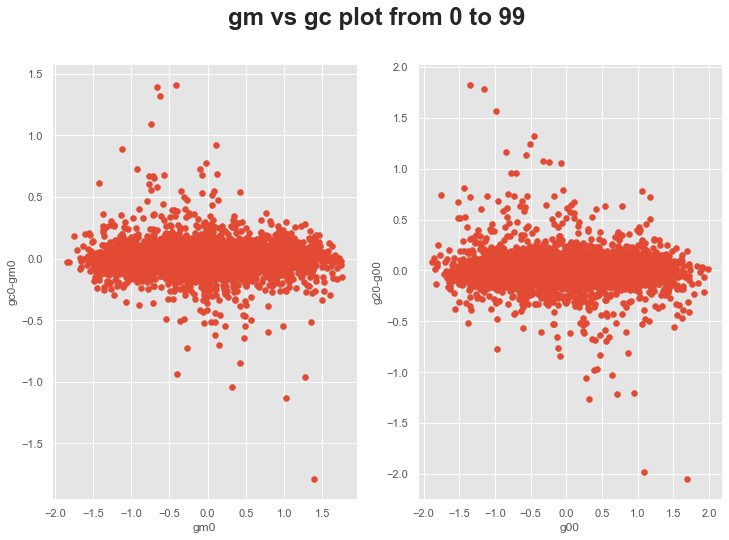

In [21]:
start = 0
end = 99
file_path = f'../data/cleancat/final_text_cleancat15_{start:03d}_{end:03d}.txt'
df = read_data(file_path)

plot_g00_20(df,start,end)

(90623, 50)


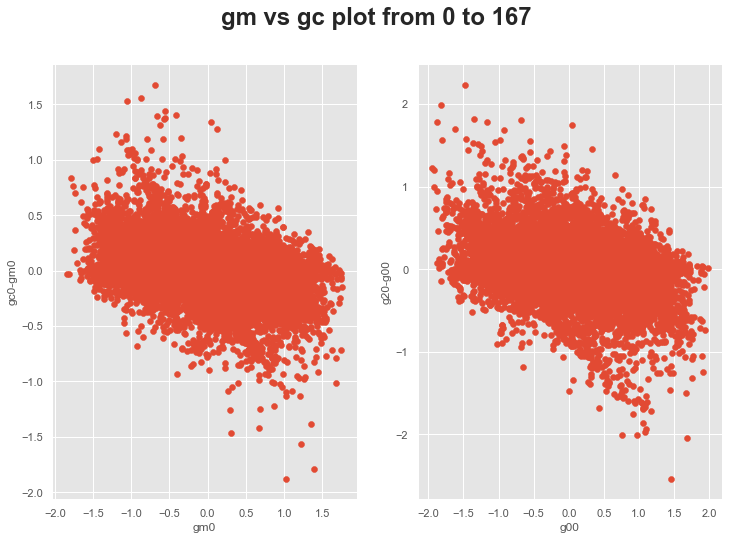

In [22]:
start = 0
end = 167
file_path = f'../data/cleancat/final_text_cleancat15_{start:03d}_{end:03d}.txt'
df = read_data(file_path)

plot_g00_20(df,start,end)